In [1]:
# import libralys
import pandas as pd
import sys


# Adding 'src' folder path to import path
sys.path.append('../src')

In [2]:
# import the Plot class
from classes import Plot

# create a plot object 
plotter = Plot(figsize=(10, 6), palette='viridis')

# import the Auxiliaries class
from classes import Auxiliaries

# import the modelling class
from classes import Modelling

modelling = Modelling()

In [3]:
# create auxiliaries object
aux = Auxiliaries(plotter)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# read the csv file
data = pd.read_csv("../data/teste_indicium_precificacao.csv")

In [5]:
# convert 'ultima_review' in data format
data['ultima_review'] = pd.to_datetime(data['ultima_review'])

# EDA

## Bairro

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


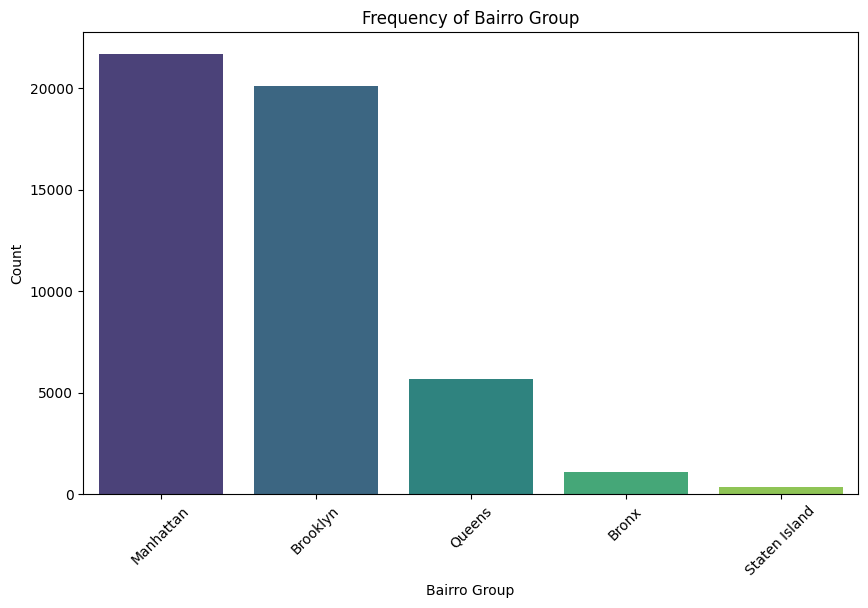

In [6]:
# bairro group count
bairro_group_count = data['bairro_group'].value_counts().reset_index()
bairro_group_count.columns = ['bairro_group', 'count']

# Using Plot class to plot bar graph
plotter.barplot(data=bairro_group_count, x_col='bairro_group', y_col='count', 
             title='Frequency of Bairro Group', xlabel='Bairro Group', ylabel='Count',
             rotation=45)  


c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


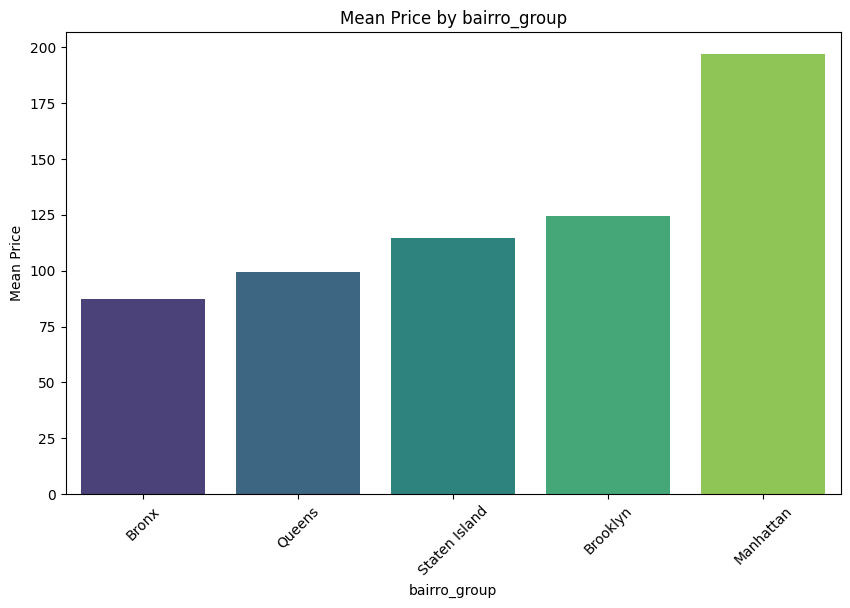

In [7]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['price'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='price', 
             title='Mean Price by bairro_group', xlabel='bairro_group', ylabel='Mean Price',
             rotation=45)

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


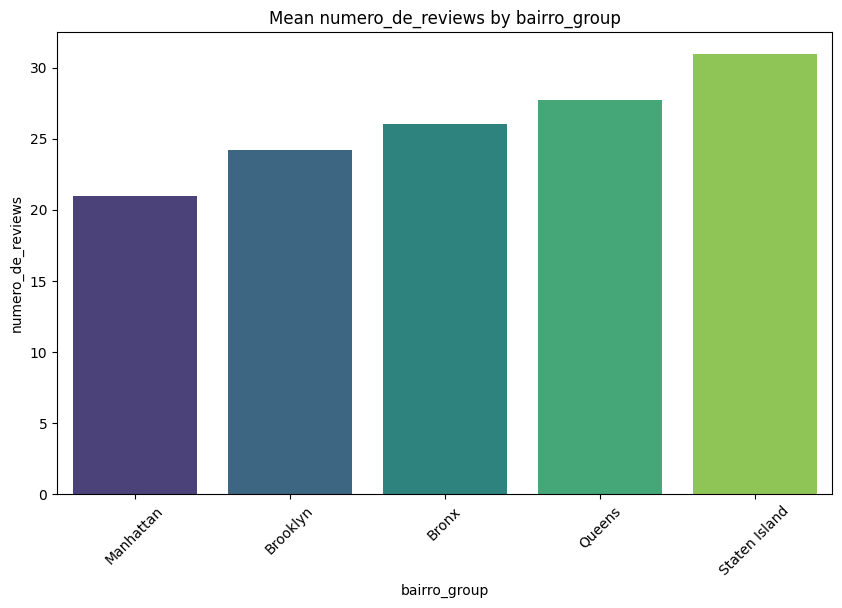

In [8]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['numero_de_reviews'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='numero_de_reviews', 
             title='Mean numero_de_reviews by bairro_group', xlabel='bairro_group', ylabel='numero_de_reviews',
             rotation=45)


c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


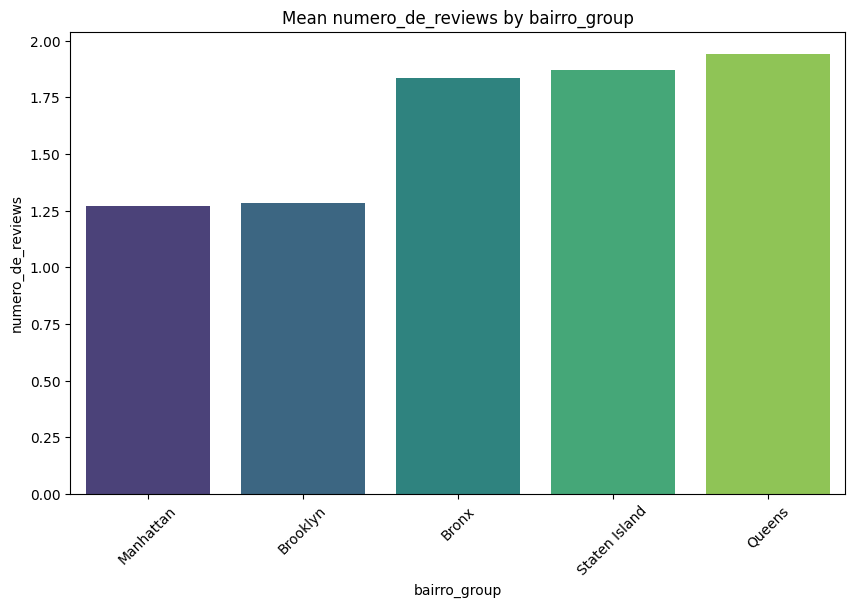

In [9]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['reviews_por_mes'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='reviews_por_mes', 
             title='Mean numero_de_reviews by bairro_group', xlabel='bairro_group', ylabel='numero_de_reviews',
             rotation=45)


## analise de palavras

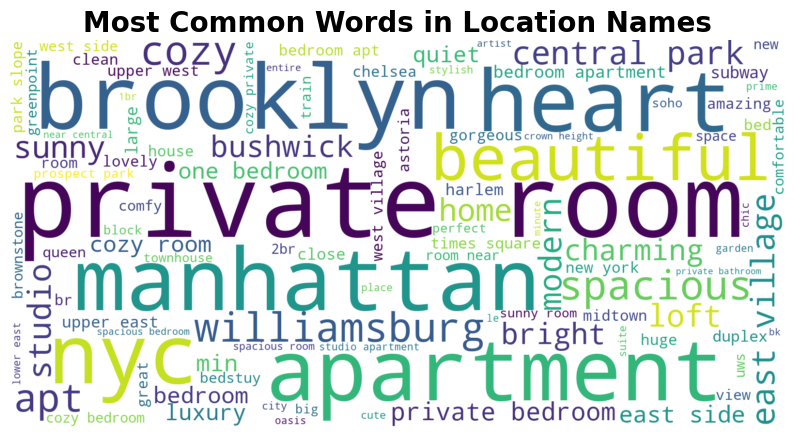

In [10]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_commom_words = plotter.plot_wordcloud(data, text_column='nome', title="Most Common Words in Location Names")


## Analise de genero

['female' 'unknown' 'male' 'andy']


c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


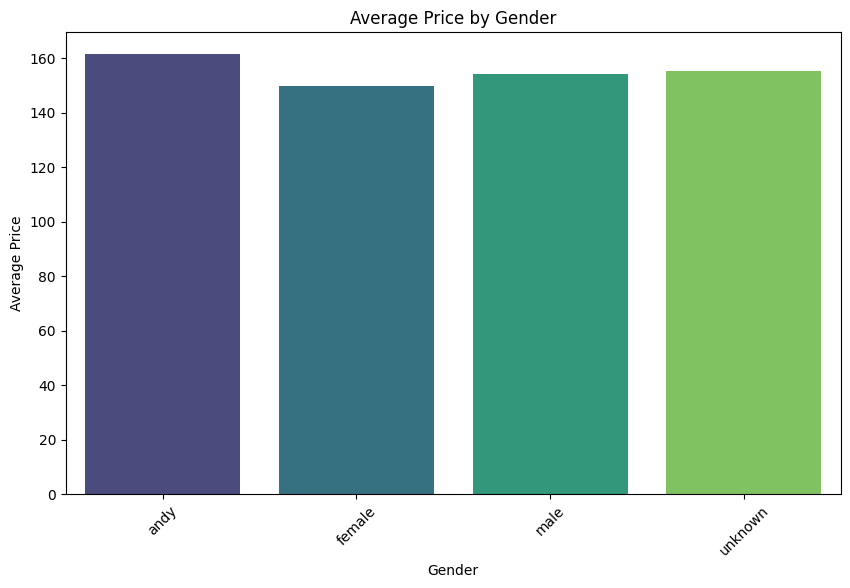

In [11]:
# Aplicate predict_gender in col 'host_name'
data['gender'] = data['host_name'].apply(lambda name: aux.predict_gender(name))

# Replace specific gender values for consistency
data['gender'] = data['gender'].replace({'mostly_female': 'female', 'mostly_male': 'male'})

# Check the unique values in the 'gender' column
print(data['gender'].unique())

# Group by 'gender' and calculate the mean price
gender_price_mean = data.groupby('gender')['price'].mean().reset_index()

# Use the Plot class to generate a bar chart
plotter.barplot(data=gender_price_mean, x_col='gender', y_col='price',
                title='Average Price by Gender', xlabel='Gender', ylabel='Average Price',
                rotation=45)


## EDA numeric

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data[y_col], palette=self.palette)


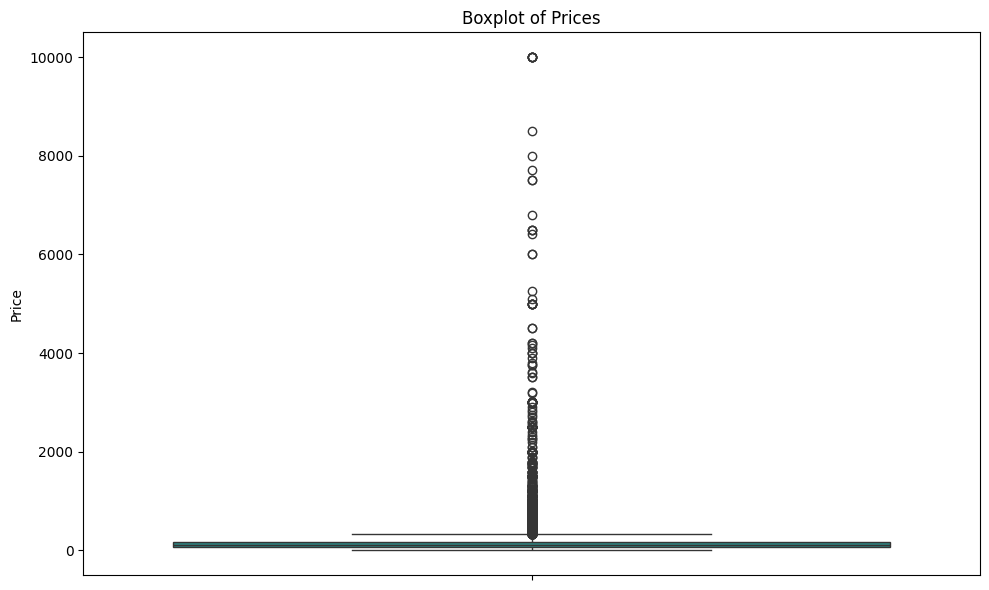

In [12]:
# Plot the boxplot for 'price' (without x_col)
plotter.boxplot(data=data, x_col= None,y_col='price', title='Boxplot of Prices', ylabel='Price')

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette=self.palette)


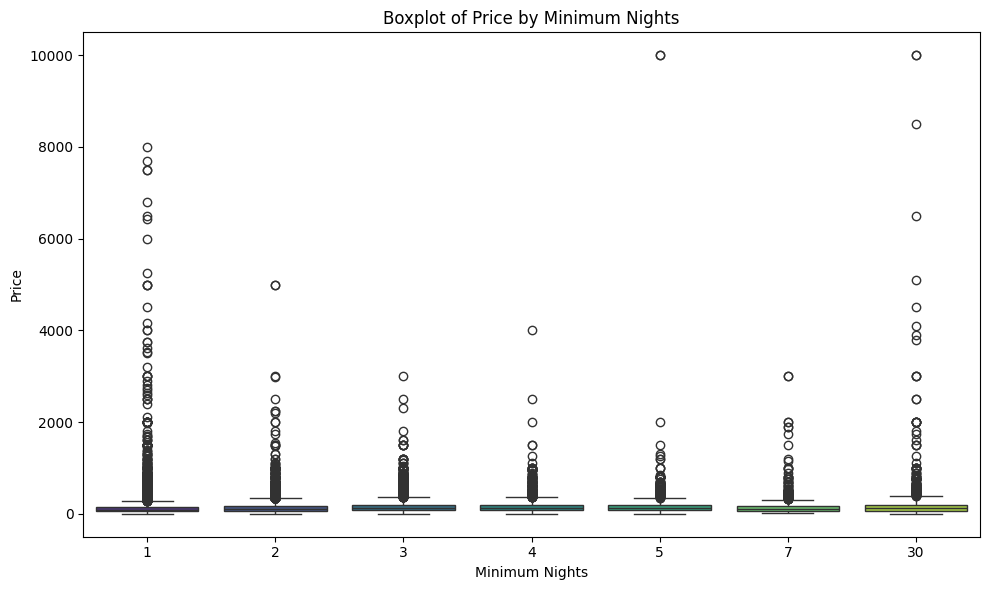

Mean prices by Minimum Nights:
minimo_noites
1     142.02
2     146.27
3     160.25
4     161.19
5     157.31
7     141.19
30    182.56
Name: price, dtype: float64


In [13]:
# Define the most common values of 'minimo_noites'
common_nights = [1, 2, 3, 30, 4, 5, 7]

# Filter the dataset to include only these values
filtered_data = data[data['minimo_noites'].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(data=filtered_data, x_col='minimo_noites', y_col='price',
                title='Boxplot of Price by Minimum Nights', xlabel='Minimum Nights', ylabel='Price')

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby('minimo_noites')['price'].mean()
print("Mean prices by Minimum Nights:")
print(mean_prices.round(2))


In [14]:
data['days_since_last_review'] = (pd.Timestamp.today() - data['ultima_review']).dt.days



c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette=self.palette)


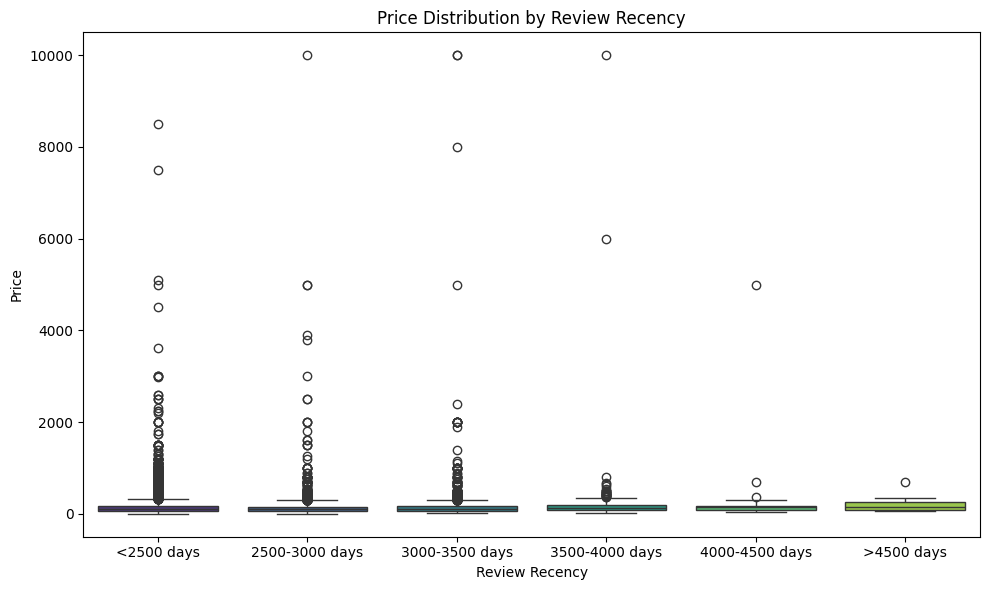

In [15]:
data['days_since_last_review'] = (pd.Timestamp.today() - data['ultima_review']).dt.days


# Ensure there are no NaN values in 'days_since_last_review'
data = data.dropna(subset=['days_since_last_review'])

# Define the bins with a lower bound (0)
data['review_recency_category'] = pd.cut(
    data['days_since_last_review'], 
    bins=[0, 2500, 3000, 3500, 4000, 4500, data['days_since_last_review'].max()], 
    labels=['<2500 days', '2500-3000 days', '3000-3500 days', '3500-4000 days', '4000-4500 days', '>4500 days']
)

# Drop NaN values again in case some remain
data = data.dropna(subset=['review_recency_category', 'price'])


plotter.boxplot(data=data, x_col='review_recency_category', y_col='price',
                title='Price Distribution by Review Recency', xlabel='Review Recency', ylabel='Price')



A p-value de 5.900678200832663e-07 é extremamente baixa (muito menor que 0.05). Isso significa que:

Rejeitamos a hipótese nula: A hipótese nula, nesse caso, era que todas as categorias de "review_recency_category" têm médias de preço iguais.
Diferenças significativas: Há evidências estatísticas fortes de que, pelo menos, uma das categorias tem uma média de preço diferente das outras.
Influência da recência: Isso sugere que a data da última avaliação (ou a recência) tem um efeito significativo sobre o preço, ou seja, os preços variam de forma estatisticamente significativa entre os diferentes grupos de recência das avaliações.
Em resumo, com esse p-value, você pode concluir que a variável "days_since_last_review" (transformada em categorias) influencia o preço de maneira significativa.

In [16]:
import scipy.stats as stats

anova_result = stats.f_oneway(
    *[group['price'].dropna() for _, group in data.groupby('review_recency_category')]
)
print("Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.")
print("Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.")
print(f"ANOVA p-value: {anova_result.pvalue}")

Se o valor p < 0,05, então a última data de revisão afeta significativamente o preço.
Se o valor p > 0,05, não há evidências fortes de que a atualidade da revisão impacta o preço.
ANOVA p-value: 7.25663929517878e-07


C:\Users\kaio\AppData\Local\Temp\ipykernel_23196\3641784038.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  *[group['price'].dropna() for _, group in data.groupby('review_recency_category')]


# questions 

# A

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=self.palette)


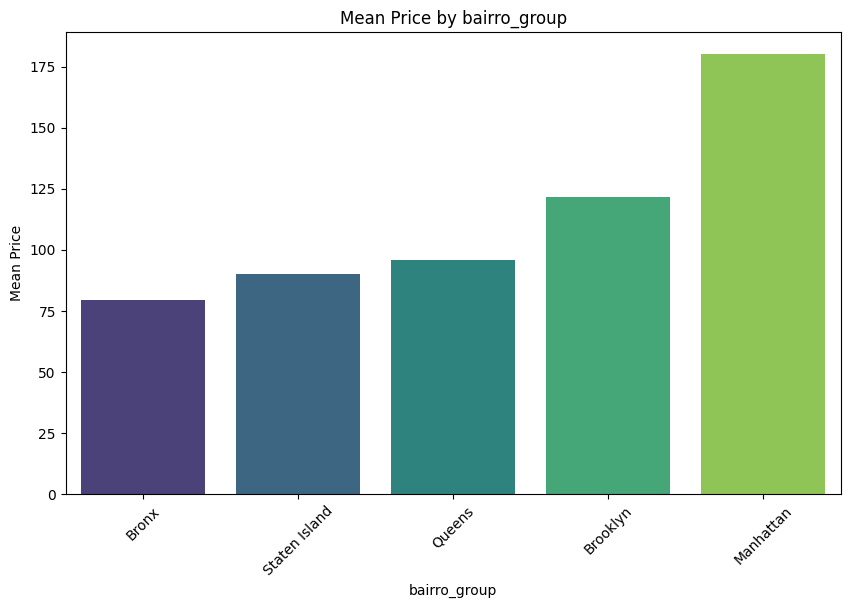

In [17]:
# Calculate the mean price by room type
mean_price_by_room_type = data.groupby('bairro_group')['price'].mean().sort_values()

# Convert to DataFrame for compatibility with the Plot class
mean_price_by_room_type_df = mean_price_by_room_type.reset_index()

# Use the Plot class to generate the bar chart
plotter.barplot(data=mean_price_by_room_type_df, x_col='bairro_group', y_col='price', 
             title='Mean Price by bairro_group', xlabel='bairro_group', ylabel='Mean Price',
             rotation=45)

# B

## b.1

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette=self.palette)


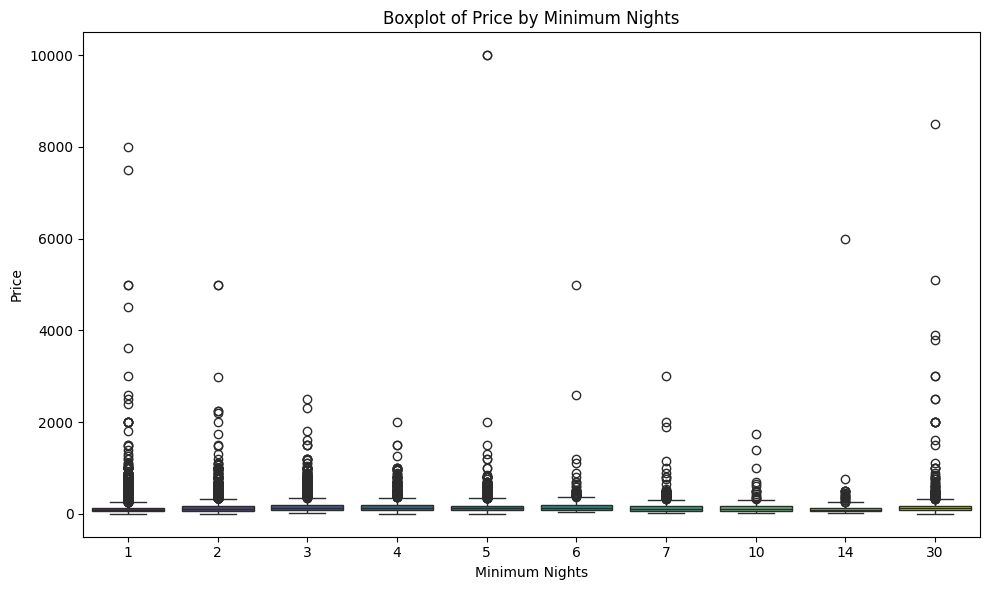

Mean prices by Minimum Nights:
minimo_noites
1     122.64
2     141.69
3     155.55
4     156.83
5     157.05
6     166.77
7     132.95
10    137.97
14    126.88
30    159.46
Name: price, dtype: float64


In [18]:
# Define the most common values of 'minimo_noites'
common_nights = data['minimo_noites'].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data = data[data['minimo_noites'].isin(common_nights)]

# Create the boxplot for 'minimo_noites' using the Plot class
plotter.boxplot(data=filtered_data, x_col='minimo_noites', y_col='price',
                title='Boxplot of Price by Minimum Nights', xlabel='Minimum Nights', ylabel='Price')

# Calculate and print the mean prices by 'minimo_noites'
mean_prices = filtered_data.groupby('minimo_noites')['price'].mean()
print("Mean prices by Minimum Nights:")
print(mean_prices.round(2))



In [19]:
import scipy.stats as stats

# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=['minimo_noites', 'price'])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(*(clean_data[clean_data['minimo_noites'] == value]['price'] 
                               for value in clean_data['minimo_noites'].unique()))

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("There is a significant relationship between 'minimo_noites' and 'price'.")
else:
    print("There is no significant relationship between 'minimo_noites' and 'price'.")

ANOVA Test Results:
F-statistic: 37.85
P-value: 0.0000
There is a significant relationship between 'minimo_noites' and 'price'.


## b.2

c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette=self.palette)


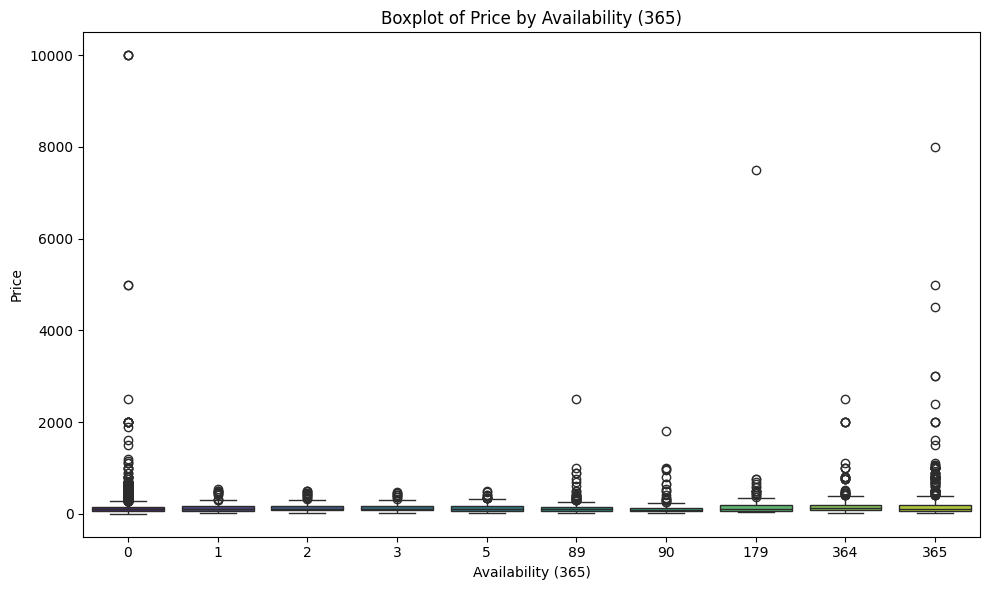

Mean prices by Availability (365):
disponibilidade_365
0      126.72
1      126.85
2      136.12
3      133.15
5      132.08
89     146.32
90     135.42
179    183.57
364    205.46
365    214.05
Name: price, dtype: float64


In [20]:
# Define the most common values of 'disponibilidade_365'
common_availability = data['disponibilidade_365'].value_counts().head(10).index

# Filter the dataset to include only these values
filtered_data_availability = data[data['disponibilidade_365'].isin(common_availability)]

# Create the boxplot for 'disponibilidade_365' using the Plot class
plotter.boxplot(data=filtered_data_availability, x_col='disponibilidade_365', y_col='price',
                title='Boxplot of Price by Availability (365)', xlabel='Availability (365)', ylabel='Price')

# Calculate and print the mean prices by 'disponibilidade_365'
mean_prices_availability = filtered_data_availability.groupby('disponibilidade_365')['price'].mean()
print("Mean prices by Availability (365):")
print(mean_prices_availability.round(2))

In [21]:
import scipy.stats as stats

# Remove any rows with missing values in 'disponibilidade_365' or 'price'
clean_data = data.dropna(subset=['disponibilidade_365', 'price'])

# Perform ANOVA (Analysis of Variance)
anova_result = stats.f_oneway(*(clean_data[clean_data['disponibilidade_365'] == value]['price'] 
                               for value in clean_data['disponibilidade_365'].unique()))

# Print the results
print("ANOVA Test Results:")
print(f"F-statistic: {anova_result.statistic:.2f}")
print(f"P-value: {anova_result.pvalue:.4f}")

# Interpretation of the results
if anova_result.pvalue < 0.05:
    print("There is a significant relationship between 'disponibilidade_365' and 'price'.")
else:
    print("There is no significant relationship between 'disponibilidade_365' and 'price'.")


ANOVA Test Results:
F-statistic: 1.75
P-value: 0.0000
There is a significant relationship between 'disponibilidade_365' and 'price'.


## 2.c

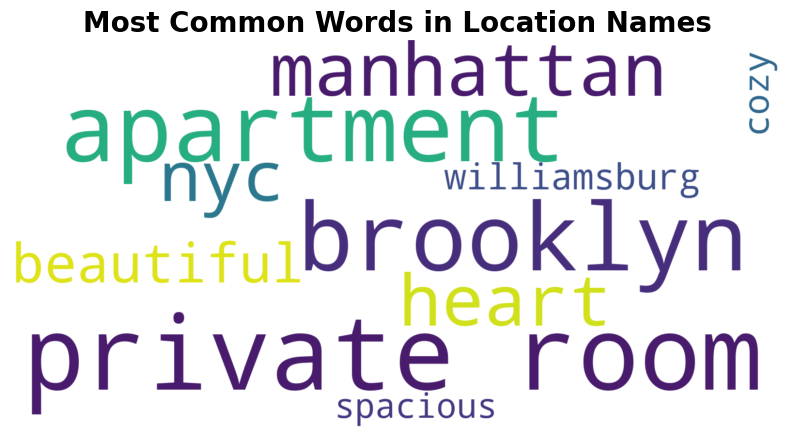

In [22]:
# Generate a word cloud for the 'nome' column in the 'data' DataFrame
df_words = plotter.plot_wordcloud(data, text_column='nome', max_words=10,title="Most Common Words in Location Names")


c:\Users\kaio\OneDrive\Área de Trabalho\LH_CD_KAIOBRASIL\notebooks\../src\classes.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=data[x_col], y=data[y_col], palette=self.palette)


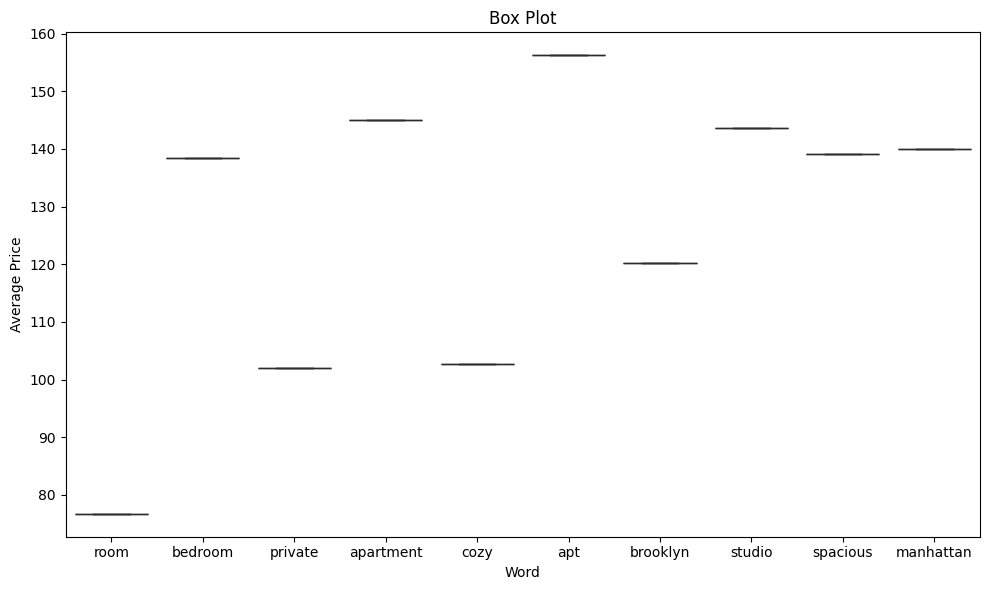

In [23]:
# plot price distribuitions form common word
df_price_distribution = aux.plot_price_distribution(data, 'nome', 'price', df_words)

# Modelling

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

data_modelling = data.copy()

# Define the collumns
categorical_features = [
    "bairro_group", "bairro", "room_type", "gender"
    ]
numerical_features = [
    "minimo_noites", "numero_de_reviews", "reviews_por_mes",
    "calculado_host_listings_count", "disponibilidade_365", "days_since_last_review"
]

# Remove rows with NaN values
data_modelling = data_modelling.dropna() 

# Transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Transformer for numeric variables
numerical_transformer = StandardScaler()

# Applying transformations to the correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


In [25]:
from sklearn.model_selection import train_test_split

# separate columns features and target
y = data_modelling["price"]
X = data_modelling.drop(columns=["price"])

# Divisão em treino (70%) e temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Divisão do temporário em validação (20%) e teste (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Aplicando as transformações do pipeline
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define the model and parameter grid
model_lr = LinearRegression()


param_grids_lr = {
    'Linear Regression': {
        'fit_intercept': [True, False],
    },
}

# Configure GridSearchCV (without automatic refitting)
grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grids_lr['Linear Regression'],
    scoring='r2',  # Important: use a string, as r2_score as a function is not accepted
    cv=5,  # Cross-validation on the training set
    n_jobs=-1,
    refit=True  
)


best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_lr,
    grid_search=grid_search_lr,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed,
    y_test=y_test
)

------------------------------Métricas de R2 para o modelo------------------------------
R² para o conjunto de validação: 0.2288
------------------------------Métricas de erro para os modelos------------------------------


              model        MAE        R2     theil
0  LinearRegression  59.627435  0.106782  0.443962


In [27]:
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define the model
model_xg = {
    'XGBoost': xg.XGBRegressor()
}

# Define the hyperparameter grid for tuning
param_grids_xg = {
    'XGBoost': {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 500],
        'max_depth': [3, 5],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0.1, 0.5],
        'reg_alpha': [1e-5, 0.1],
        'reg_lambda': [1e-5, 0.1]
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_xg = GridSearchCV(
    estimator=xg.XGBRegressor(), 
    param_grid=param_grids_xg['XGBoost'],
    scoring=r2_score,
    cv=5,
    n_jobs=-1
)

best_model, best_estimator = modelling.train_and_evaluate_with_gridsearch(
    model=model_xg,
    grid_search=grid_search_xg,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val,
    X_test=X_test_transformed
)


TypeError: Modelling.train_and_evaluate_with_gridsearch() missing 1 required positional argument: 'y_test'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Define the model
model_rf = {
    'Random Forest': RandomForestRegressor()
}

# Define the hyperparameter grid for tuning
param_grids_rf = {
    'Random Forest': {
        'n_estimators': [100, 500],  # Number of trees in the forest
        'max_depth': [None, 10, 20],  # Maximum depth of the trees
        'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 4],  # Minimum number of samples required in a leaf node
        'max_features': ['sqrt', 'log2'],  # Number of features to consider for each split
        'bootstrap': [True, False]  # Whether to use bootstrapping
    }
}

# Configure GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(),  # Random Forest model
    param_grid=param_grids_rf['Random Forest'],  # Defined hyperparameter grid
    scoring='r2',  # R² score as the evaluation metric
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available processor cores for parallel processing
)

# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

# Train the best model using the found hyperparameters
best_model_rf = RandomForestRegressor(**best_params_rf)
best_model_rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_val_pred_rf = best_model_rf.predict(X_val_transformed)
modelling.print_R2_validation(y_val, y_val_pred_rf)

# Now we can use this model on the test set
y_test_pred_rf = best_model_rf.predict(X_test_transformed)

# Compute residuals for the model's predictions
modelling.ResidualForModels(models=[best_model_rf], y_pred=y_test_pred_rf)

# Compute accuracy metrics for the model
modelling.computeAccuracyModels(models=[best_model_rf], y_pred=y_test_pred_rf)
